## Вакансии с платформы "Работа в России"

### Загрузка и очистка данных

In [1]:
import pandas as pd
import json
from flatten_json import flatten
import requests
import math
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt
from collections import Counter
import re
import seaborn as sns
from matplotlib.dates import MonthLocator
from matplotlib.ticker import PercentFormatter
import statistics
import numpy as np


In [31]:
df = pd.read_csv('../output/MAIN dataset.csv')
df.head(3)

,Unnamed: 0.1,Unnamed: 0,vacancy_id,vacancy_source,vacancy_region_region_code,vacancy_region_name,vacancy_company_companycode,vacancy_company_email,vacancy_company_hr-agency,vacancy_company_inn,...,vacancy_skills_19,vacancy_skills_20,vacancy_skills_21,vacancy_skills_22,vacancy_skills_23,vacancy_skills_24,vacancy_skills_25,vacancy_medicalCertificate,vacancy_workPlaceType_workPlaceDisabilityGroup,vacancy_workPlaceType_workPlaceSocialProtected_5
0,0,0,98461b12-beb6-11ed-a2e7-93f7cc862eb6,Работодатель,100000000000,Республика Адыгея (Адыгея),8f182f10-ad82-11e7-9505-4376a32b3f45,kras_crb@mail.ru,False,102002416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,3ffa5e58-b601-11ef-9100-cb26dff57dd7,Работодатель,200000000000,Республика Башкортостан,1060256009241,pckb@yandex.ru,False,256017557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,6c108618-3ab1-11f0-8259-d549be31d974,Кадровое агентство,200000000000,Республика Башкортостан,1040201496301,medikcrb1@mail.ru,True,212004600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df.shape

(1437, 96)

In [10]:
df.columns

Index(['id', 'region_region_code', 'region_name', 'vac_url', 'creation-date',
       'code_profession', 'job-name', 'employment', 'salary_min', 'salary_max',
       'salary_avg', 'duty', 'term_text', 'personnel'],
      dtype='object')

In [ ]:
# # for MAIN (w/o personnel) dataset
# df.columns = [col.replace('vacancy_', '') for col in df.columns]
# # df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
# # приводим коды профессий и дату создания вакансии к удобному формату данных
# df['code_profession'] = df['code_profession'].astype('string')
# df['creation-date']=df['creation-date'].astype('datetime64[ns]')

In [ ]:
# for MAIN df w/o personnel
print(f"Кол-во строк и столбцов:{df.shape}", "\nНазвание колонок:\n", df.columns)

Кол-во строк и столбцов:(1431, 14) 
Название колонок:
 Index(['id', 'region_region_code', 'region_name', 'vac_url', 'creation-date',
       'code_profession', 'job-name', 'employment', 'salary_min', 'salary_max',
       'salary_avg', 'duty', 'term_text', 'personnel'],
      dtype='object')


In [14]:
df['region_name'].isna().describe()

count      1431
unique        1
top       False
freq       1431
Name: region_name, dtype: object

In [54]:
pd.set_option('display.max_rows', 1000)
df.isnull().sum()

Unnamed: 0.1                                   0
Unnamed: 0                                     0
id                                             0
source                                         0
region_region_code                             0
region_name                                   33
company_companycode                            0
company_email                                 19
company_hr-agency                              0
company_inn                                    0
company_kpp                                    1
company_name                                   0
company_ogrn                                   0
company_url                                    0
creation-date                                  0
salary                                         2
salary_min                                     0
salary_max                                     0
job-name                                       0
vac_url                                        0
employment          

In [61]:
# по коду профессии ОКПДТР удаляем вакансии, которые не относятся к акушерству 
irrelevant_codes = ['181121.0', '204751.0', '204613.0', '221047.0']
df = df[~df['code_profession'].isin(irrelevant_codes)]

In [62]:
df = df[['id', 'region_region_code', 'region_name', 'vac_url', 'creation-date', 'code_profession', 'job-name', 'employment', 'salary_min', 'salary_max', 'duty', 'term_text']]
df.head()

,id,region_region_code,region_name,vac_url,creation-date,code_profession,job-name,employment,salary_min,salary_max,duty,term_text
0,98461b12-beb6-11ed-a2e7-93f7cc862eb6,100000000000,Республика Адыгея (Адыгея),https://trudvsem.ru/vacancy/card/8f182f10-ad82...,2023-03-09,204554.0,Врач-акушер-гинеколог,Полная занятость,25000,40000,Оказывает квалифицированную медицинскую помощь...,Социальный пакет
1,3ffa5e58-b601-11ef-9100-cb26dff57dd7,200000000000,Республика Башкортостан,https://trudvsem.ru/vacancy/card/1060256009241...,2024-12-09,204484.0,врач акушер -гинеколог,Полная занятость,45000,0,для врача акушер гинеколога,NaN
2,6c108618-3ab1-11f0-8259-d549be31d974,200000000000,Республика Башкортостан,https://trudvsem.ru/vacancy/card/1040201496301...,2025-05-27,200869.0,Акушер,Полная занятость,30000,30000,"осуществляет амбулаторный прием,проводит осмот...",-Социальный пакет -Социальные выплаты - Компен...
3,a20f9278-3ab0-11f0-bd48-cb26dff57dd7,200000000000,Республика Башкортостан,https://trudvsem.ru/vacancy/card/1020202281758...,2025-05-27,200869.0,Акушер,Полная занятость,25806,42956,Оказание доврачебной медицинской помощи береме...,NaN
4,cc627cc5-9374-11ee-b9ef-e7d0d2cf29b1,200000000000,Республика Башкортостан,https://trudvsem.ru/vacancy/card/1030204437966...,2023-12-05,200869.0,Акушер,Полная занятость,40000,50000,Оказание медицинской помощи по профилю акушерс...,NaN


In [ ]:
# add_updates = df[['id', 'vac_url']].copy()
# add_updates.to_csv('../output/add_updates.csv', index=False)

### Преобразование данных

In [ ]:
# удаляем лишние колонки с индексами и вакансии, размещенные раньше мая 2023 года
# df = df.loc[df['creation-date'] >= '2023-05-01']

In [63]:
personnel = pd.read_csv('../data/personnel category.csv')
personnel['code_profession'] = personnel['code_profession'].astype('string')

In [64]:
code_to_personnel = dict(zip(personnel['code_profession'], personnel['вид персонала']))

def assign_personnel(code_profession):
    # Return the personnel category for the given code_profession, or None if not found
    return code_to_personnel.get(code_profession, None)

df['personnel'] = df['code_profession'].apply(assign_personnel)

In [65]:
df['personnel'].value_counts()

personnel
старший    1020
средний     393
Name: count, dtype: int64

In [ ]:
# df.to_excel('../output/MAIN dataset with personnel.xlsx', index=False)

### Осмотр данных (MAIN w/ personnel)

In [33]:
df = pd.read_excel('../output/MAIN dataset with personnel.xlsx', sheet_name='main')
df.shape

(1431, 14)

In [40]:
df.columns

Index(['id', 'region_region_code', 'region_name', 'vac_url', 'creation-date',
       'code_profession', 'job-name', 'employment', 'salary_min', 'salary_max',
       'salary_avg', 'duty', 'term_text', 'personnel'],
      dtype='object')

In [51]:
df['region_name'].describe()

count                   1431
unique                    83
top       Краснодарский край
freq                      86
Name: region_name, dtype: object

In [21]:
# For every unique code_profession, find the most common job-name
most_common_jobname = (
    df.groupby('code_profession')['job-name']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
    .rename(columns={'job-name': 'most_common_job_name'})
)
most_common_jobname

,code_profession,most_common_job_name
0,200017.0,Акушер
1,200869.0,Акушер
2,204484.0,Врач-акушер-гинеколог
3,204499.0,Врач акушер-гинеколог
4,204554.0,Врач-акушер-гинеколог
5,204639.0,Врач-акушер-гинеколог
6,204696.0,врач-акушер-гинеколог
7,220383.0,Заведующий отделением (в прочих должностях)
8,240387.0,Заведующий фельдшерско-акушерским пунктом - фе...
9,242753.0,Медицинская сестра/медицинский брат гинекологи...


#### Кол-во вакансий

In [53]:
df['year'] = df['creation-date'].dt.year
regions_per_year_personnel = (
    df.groupby(['year', 'personnel'])['region_name']
    .nunique()
    .unstack(fill_value=0)
)
print(regions_per_year_personnel)

personnel  средний  старший
year                       
2015             1       11
2016             0        3
2017             1        2
2018             0        2
2019             1       10
2020             1       13
2021             6       26
2022            33       52
2023            39       58
2024            45       72
2025            58       72


In [30]:
# Group by month and personnel, count number of vacancies
vacancies_by_month_personnel = (
    df_2024_2025.groupby(['month', 'personnel'])['id']
    .count()
    .unstack(fill_value=0)
    .sort_index()
)

print(vacancies_by_month_personnel)


personnel  средний  старший
month                      
2024-01          8       14
2024-02          6       31
2024-03          1       11
2024-04          4        9
2024-05          2       20
2024-06          6       15
2024-07          5       12
2024-08          6       29
2024-09         10       23
2024-10         12       19
2024-11          8       22
2024-12         11       35
2025-01         18       36
2025-02         33       66
2025-03         29       56
2025-04         49      135
2025-05         43      128


#### Зарплата в целом

In [22]:
# Группировка по code_profession и расчет средних значений salary_min и salary_max
df.groupby('personnel')[['salary_min', 'salary_max']].mean().loc[
    df['personnel'].value_counts(ascending=False).index
]

,salary_min,salary_max
personnel,,
старший,64692.462802,77109.488889
средний,36466.340909,41823.290404


In [91]:
top10_salary_min = df.groupby('region_name')['salary_min'].max().sort_values(ascending=False).head(10)
top10_salary_min

region_name
Ямало-Ненецкий автономный округ             250000
Город Москва                                220000
Сахалинская область                         200000
Чукотский автономный округ                  190000
Тюменская область                           180000
Республика Саха (Якутия)                    180000
Ханты-Мансийский автономный округ - Югра    180000
Камчатский край                             180000
Московская область                          165000
Иркутская область                           160000
Name: salary_min, dtype: int64

In [ ]:
median_salary_table = df.groupby(['region_name', 'personnel'])['salary_min'].median().unstack()
print(median_salary_table)
# median_salary_table.to_excel('../output/salaries_by_region.xlsx')

personnel                                 средний   старший
region_name                                                
Алтайский край                            28050.0   35000.0
Амурская область                          50000.0   47500.0
Архангельская область                     75000.0   60000.0
Астраханская область                      23720.0   30000.0
Белгородская область                      28000.0   54570.0
Брянская область                          30000.0   42500.0
Владимирская область                      40000.0   76405.5
Волгоградская область                     26384.5   35515.0
Вологодская область                       26000.0   70000.0
Воронежская область                       34402.5   40000.0
Город Санкт-Петербург                     42500.0   77500.0
Город Севастополь                         35000.0   70000.0
Еврейская автономная область                  NaN   80000.0
Забайкальский край                        35000.0   62000.0
Ивановская область                      

In [90]:
df['region_name'].value_counts()

region_name
Краснодарский край                          86
Алтайский край                              52
Свердловская область                        50
Иркутская область                           45
Ростовская область                          43
Хабаровский край                            41
Самарская область                           39
Новосибирская область                       39
Саратовская область                         34
Кемеровская область - Кузбасс               33
Ставропольский край                         28
Республика Татарстан (Татарстан)            28
Омская область                              28
Челябинская область                         27
Республика Башкортостан                     26
Красноярский край                           26
Томская область                             26
Волгоградская область                       25
Кировская область                           25
Воронежская область                         23
Ленинградская область                       23
П

In [68]:
df[df['personnel'] == 'средний']['region_name'].value_counts(ascending=False)

region_name
Алтайский край                              21
Краснодарский край                          19
Иркутская область                           18
Томская область                             17
Хабаровский край                            17
Самарская область                           15
Волгоградская область                       10
Калужская область                           10
Омская область                              10
Саратовская область                          9
Кировская область                            9
Республика Татарстан (Татарстан)             8
Ленинградская область                        8
Тверская область                             8
Ростовская область                           7
Новосибирская область                        7
Новгородская область                         7
Свердловская область                         7
Тамбовская область                           7
Нижегородская область                        7
Республика Бурятия                           7
Р

In [ ]:
# зарплаты ниже мрот 2025 года
pd.set_option('display.max_colwidth', None)
df.loc[df['salary_min'] < 22440, 'vac_url']

49      https://trudvsem.ru/vacancy/card/c8a63d50-dd9b-11ec-ba26-550ed7335bbe/251f0830-21c5-11f0-9de6-d549be31d974
118                            https://trudvsem.ru/vacancy/card/1021500510679/a89dc075-b38f-11ee-96a1-e7d0d2cf29b1
119                            https://trudvsem.ru/vacancy/card/1021500581464/4a0a91a8-6f78-11ef-8a30-d549be31d974
343                            https://trudvsem.ru/vacancy/card/1022400667520/6119db00-db91-11ef-9c1f-295bfdef1967
452                            https://trudvsem.ru/vacancy/card/1022502128220/49eb15b7-70cb-11ef-8092-d7f294e00a65
461                            https://trudvsem.ru/vacancy/card/1032900028787/2a8c7ae8-1154-11f0-a7cf-e7d0d2cf29b1
667                            https://trudvsem.ru/vacancy/card/1194027005028/62bbb0f8-37a3-11f0-8895-cb26dff57dd7
712                            https://trudvsem.ru/vacancy/card/1024201364560/925cfe78-3a99-11ef-8e53-cb26dff57dd7
715                            https://trudvsem.ru/vacancy/card/1024202128994/35

In [ ]:
# выделяем из массива данных только вакансии с полной занятостью
# filtered_df = filtered_df[filtered_df['vacancy_employment'] == 'Полная занятость']

In [108]:
df[(df['salary_min'] <= 22440) & (df['employment'] == 'Полная занятость')]['region_name'].describe()

count                     61
unique                    28
top       Ростовская область
freq                      10
Name: region_name, dtype: object

### Визуализация данных

In [ ]:
# which schools are searching for the majority of vacancies by region
most_frequent_schools = filtered_df.groupby('vacancy_region_name')['company_name_copy'].value_counts().reset_index(name='count')
most_frequent_schools.columns = ['vacancy_region_name', 'Most Frequent School', 'Count']
most_frequent_schools = most_frequent_schools.sort_values(by='Count', ascending=False)
most_frequent_schools = most_frequent_schools.drop_duplicates(subset='vacancy_region_name')
total_vacancies = filtered_df.groupby('vacancy_region_name')['vacancy_id'].count().reset_index(name='Total Vacancies')
most_frequent_schools = most_frequent_schools.merge(total_vacancies, on='vacancy_region_name')

most_frequent_schools.to_clipboard()

In [ ]:
# which regions have mean salaries higher than Rosstat 2024 average (58109)
mean_salary_by_region = filtered_df.groupby('vacancy_region_name')['vacancy_salary_min'].mean()
filter_regions = mean_salary_by_region[mean_salary_by_region >= 58109].index.tolist()
filtered_df[filtered_df['vacancy_region_name'].isin(filter_regions)]['vacancy_region_name'].value_counts()

Ямало-Ненецкий автономный округ    143
Город Москва                        75
Магаданская область                 34
Чукотский автономный округ          10
Name: vacancy_region_name, dtype: int64

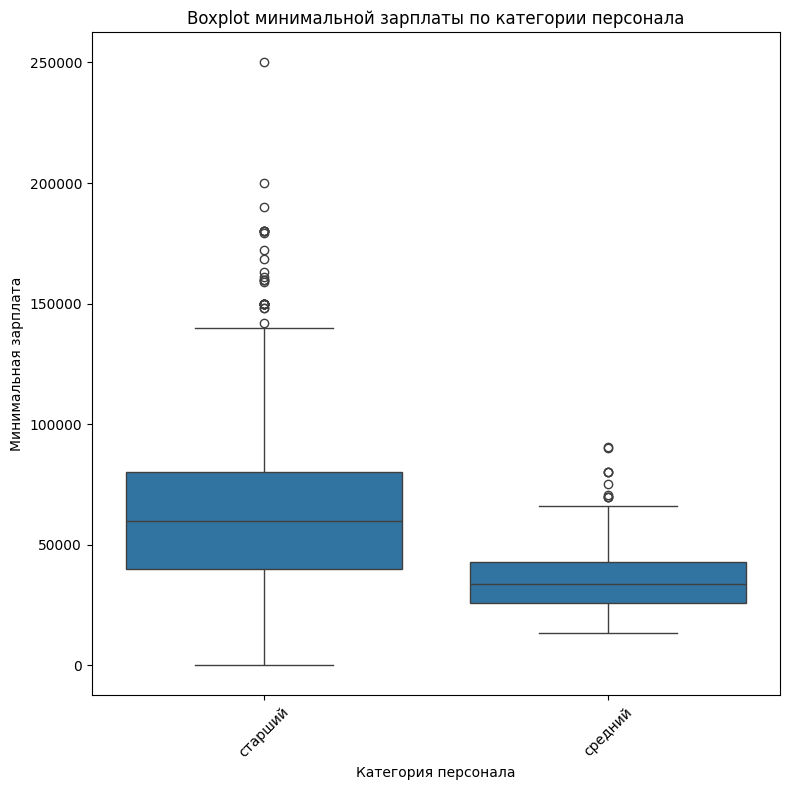

In [90]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=df, x='personnel', y='salary_min')
plt.xlabel('Категория персонала')
plt.ylabel('Минимальная зарплата')
plt.title('Boxplot минимальной зарплаты по категории персонала')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

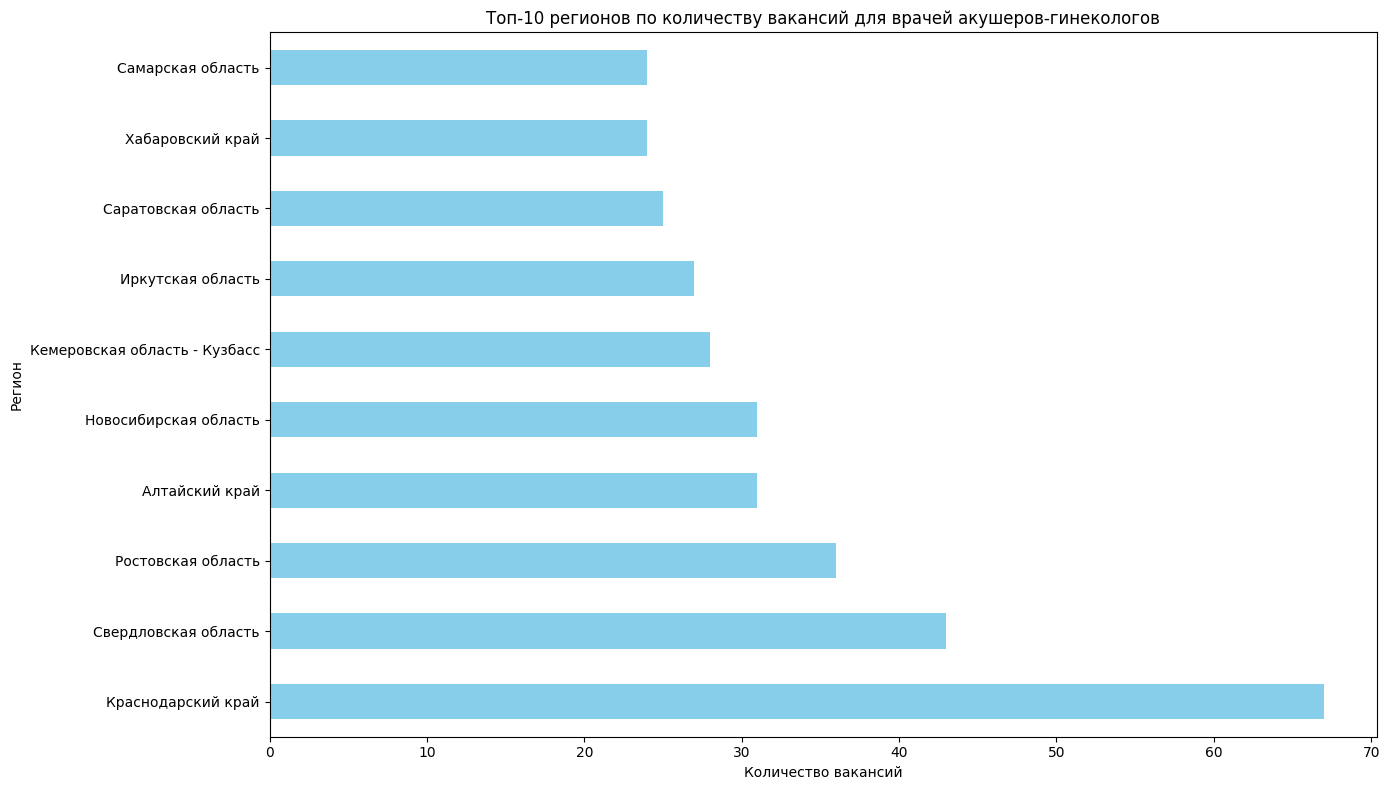

In [87]:
counts = df[df['personnel'] == 'старший']['region_name'].value_counts(ascending=False).head(10)
plt.figure(figsize=(14, 8))
counts.plot(kind='barh', color='skyblue')
plt.xlabel('Количество вакансий')
plt.ylabel('Регион')
plt.title('Топ-10 регионов по количеству вакансий для врачей акушеров-гинекологов')
plt.tight_layout()
plt.show()

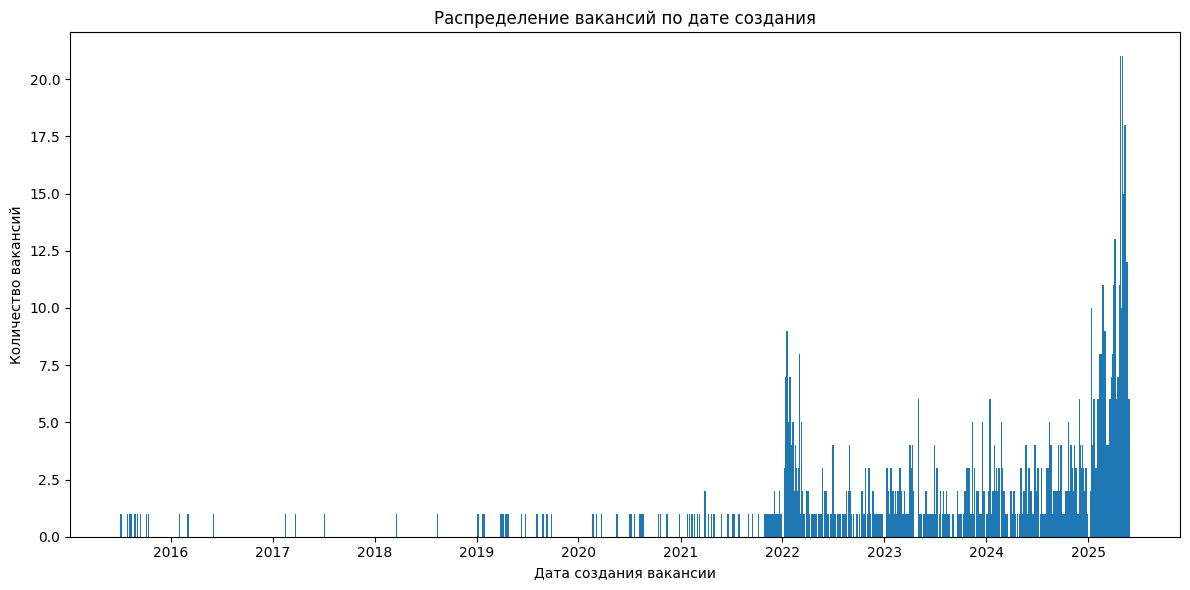

In [65]:
plt.figure(figsize=(12, 6))
# Convert 'creation-date' to datetime and count vacancies per date
date_counts = pd.to_datetime(df['creation-date']).value_counts().sort_index()
plt.bar(date_counts.index, date_counts.values, width=5)
plt.xlabel('Дата создания вакансии')
plt.ylabel('Количество вакансий')
plt.title('Распределение вакансий по дате создания')
plt.tight_layout()
plt.show()

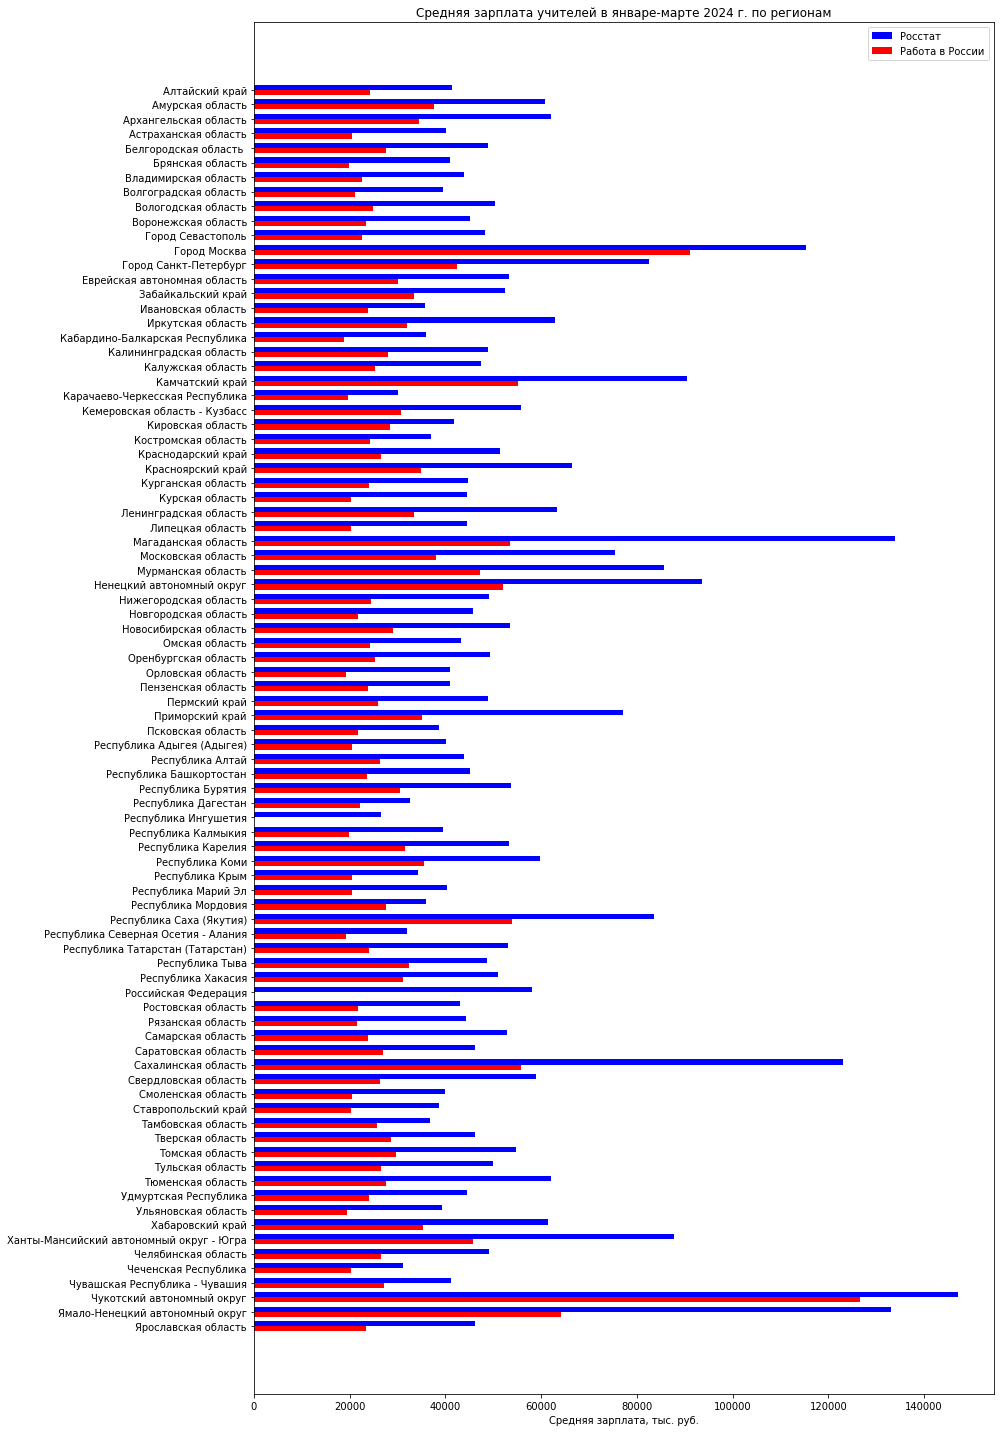

In [ ]:
# Setting the position of the bars on the y-axis
bar_width = 0.35  # Width of the bars

# Creating the bar chart
fig, ax = plt.subplots(figsize=(14, 20))

# Positions of the bars on the y-axis
y_positions = range(len(graph_data['region']))

# Plotting the bars
ax.barh(y_positions, graph_data['mean salary'], height=bar_width, color='blue', label='Росстат')
ax.barh([p + bar_width for p in y_positions], graph_data['mean salary RaRu'], height=bar_width, color='red', label='Работа в России')

# Adding labels
ax.set_yticks([p + bar_width / 2 for p in y_positions])
ax.set_yticklabels(graph_data['region'])
ax.set_xlabel('Средняя зарплата, тыс. руб.')
ax.set_title('Средняя зарплата учителей в январе-марте 2024 г. по регионам')
ax.legend()

# Inverting the y-axis to have the first region on top
plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()

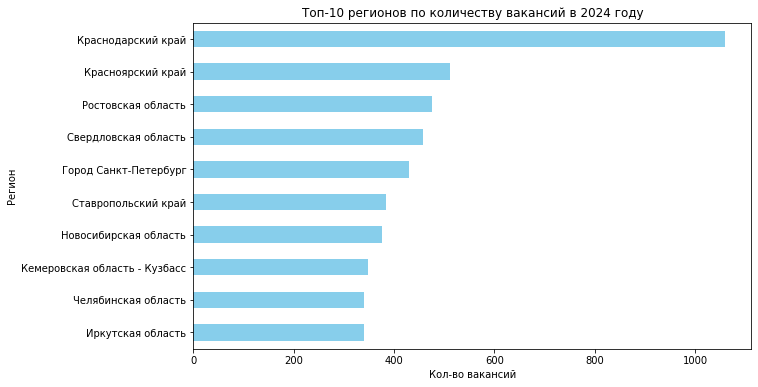

In [ ]:
# # горизонтальная столбиковая диаграмма регионов по количеству вакансий в 2023 году
# most_vacancies.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='skyblue')
# plt.title('Топ-10 регионов по количеству вакансий в 2024 году')
# plt.ylabel('Регион')
# plt.xlabel('Кол-во вакансий')
# plt.show()

In [ ]:
data = filtered_df.loc[filtered_df['vacancy_salary_min'] != 0]
# data = data.loc[data['vacancy_creation-date'].dt.year >= 2023]

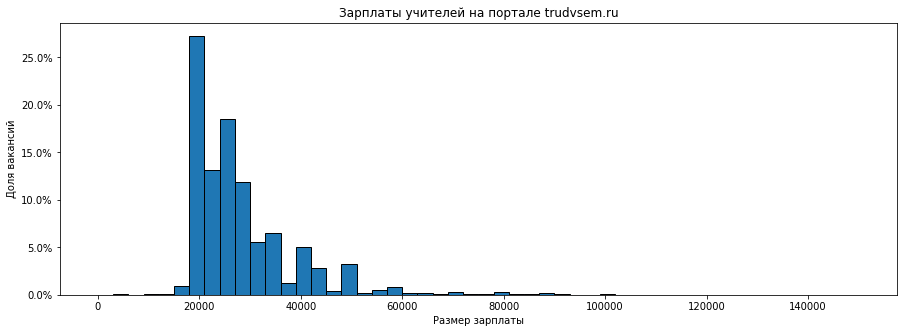

In [ ]:
graph_data = data['vacancy_salary_min']
g_weights = np.ones(len(graph_data))/len(graph_data)

fig, ax = plt.subplots(figsize=(15, 5))

# Creating the histogram with relatively thin bars
plt.hist(graph_data, bins=50, weights=g_weights, edgecolor = 'black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Размер зарплаты')
plt.ylabel('Доля вакансий')
plt.title('Зарплаты учителей на портале trudvsem.ru')
plt.show()